# Notebook goal: To develop a machine learning model that can accurately detect phishing websites based on behavioral and structural features.

## Data cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


Mounted at /content/drive


In [ ]:
np.random.seed(42)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Phishing_Legitimate_full.csv')

In [ ]:
df.head()

NameError: name 'df' is not defined

In [ ]:
column_rename_map = {
    'id': 'id',
    'NumDots': 'url_dot_count',
    'SubdomainLevel': 'subdomain_depth',
    'PathLevel': 'path_depth',
    'UrlLength': 'url_length',
    'NumDash': 'url_dash_count',
    'NumDashInHostname': 'hostname_dash_count',
    'AtSymbol': 'has_at_symbol',
    'TildeSymbol': 'has_tilde_symbol',
    'NumUnderscore': 'url_underscore_count',
    'NumPercent': 'url_percent_count',
    'NumQueryComponents': 'query_param_count',
    'NumAmpersand': 'url_ampersand_count',
    'NumHash': 'url_hash_count',
    'NumNumericChars': 'url_numeric_char_count',
    'NoHttps': 'no_https',
    'RandomString': 'has_random_string',
    'IpAddress': 'uses_ip_address',
    'DomainInSubdomains': 'domain_in_subdomains',
    'DomainInPaths': 'domain_in_path',
    'HttpsInHostname': 'https_in_hostname',
    'HostnameLength': 'hostname_length',
    'PathLength': 'path_length',
    'QueryLength': 'query_length',
    'DoubleSlashInPath': 'double_slash_in_path',
    'NumSensitiveWords': 'sensitive_word_count',
    'EmbeddedBrandName': 'has_embedded_brand',
    'PctExtHyperlinks': 'pct_external_links',
    'PctExtResourceUrls': 'pct_external_resources',
    'ExtFavicon': 'external_favicon',
    'InsecureForms': 'has_insecure_forms',
    'RelativeFormAction': 'has_relative_form_action',
    'ExtFormAction': 'external_form_submission',
    'AbnormalFormAction': 'abnormal_form_action',
    'PctNullSelfRedirectHyperlinks': 'pct_null_self_redirect_links',
    'FrequentDomainNameMismatch': 'domain_name_mismatch',
    'FakeLinkInStatusBar': 'fake_status_bar_link',
    'RightClickDisabled': 'right_click_disabled',
    'PopUpWindow': 'has_popup_windows',
    'SubmitInfoToEmail': 'submits_to_email',
    'IframeOrFrame': 'has_iframe_or_frame',
    'MissingTitle': 'missing_title',
    'ImagesOnlyInForm': 'images_only_in_form',
    'SubdomainLevelRT': 'rt_subdomain_depth',
    'UrlLengthRT': 'rt_url_length',
    'PctExtResourceUrlsRT': 'rt_pct_external_resources',
    'AbnormalExtFormActionR': 'rt_abnormal_form_action',
    'ExtMetaScriptLinkRT': 'rt_external_scripts',
    'PctExtNullSelfRedirectHyperlinksRT': 'rt_pct_null_redirect_links',
    'CLASS_LABEL': 'is_phishing'
}

# Rename the columns
df_renamed = df.rename(columns=column_rename_map)

In [ ]:
# Define feature groups
url_structure_features = [
    'url_dot_count', 'subdomain_depth', 'path_depth', 'url_length',
    'url_dash_count', 'hostname_dash_count', 'has_at_symbol',
    'has_tilde_symbol', 'url_underscore_count', 'url_percent_count',
    'query_param_count', 'url_ampersand_count', 'url_hash_count',
    'url_numeric_char_count', 'double_slash_in_path'
]

security_indicators = [
    'no_https', 'has_random_string', 'uses_ip_address',
    'https_in_hostname', 'hostname_length', 'path_length', 'query_length'
]

website_content_features = [
    'domain_in_subdomains', 'domain_in_path', 'sensitive_word_count',
    'has_embedded_brand', 'pct_external_links', 'pct_external_resources',
    'external_favicon', 'has_insecure_forms', 'has_relative_form_action',
    'external_form_submission', 'abnormal_form_action', 'pct_null_self_redirect_links'
]

behavioral_features = [
    'domain_name_mismatch', 'fake_status_bar_link', 'right_click_disabled',
    'has_popup_windows', 'submits_to_email', 'has_iframe_or_frame',
    'missing_title', 'images_only_in_form'
]

realtime_features = [
    'rt_subdomain_depth', 'rt_url_length', 'rt_pct_external_resources',
    'rt_abnormal_form_action', 'rt_external_scripts', 'rt_pct_null_redirect_links'
]

target = 'is_phishing'

# Create a list of all features
all_features = url_structure_features + security_indicators + website_content_features + behavioral_features + realtime_features


## Data analysis

In [ ]:
# Separate continuous and binary features
binary_features = [
    'has_at_symbol', 'has_tilde_symbol', 'has_random_string', 'uses_ip_address',
    'domain_in_subdomains', 'domain_in_path', 'https_in_hostname', 'has_embedded_brand',
    'external_favicon', 'has_insecure_forms', 'has_relative_form_action', 'external_form_submission',
    'abnormal_form_action', 'fake_status_bar_link', 'right_click_disabled', 'has_popup_windows',
    'submits_to_email', 'has_iframe_or_frame', 'missing_title', 'images_only_in_form'
]

continuous_features = [col for col in df_renamed.columns if col not in binary_features + ['id', 'is_phishing']]

# Standardize continuous features using Min-Max Scaling
scaler = MinMaxScaler()
df_scaled = df_renamed.copy()
df_scaled[continuous_features] = scaler.fit_transform(df_renamed[continuous_features])

# Calculate the mean for binary and continuous features for phishing and legitimate websites
phishing_features = df_scaled[df_scaled['is_phishing'] == 1].drop(columns=['id', 'is_phishing']).mean()
legit_features = df_scaled[df_scaled['is_phishing'] == 0].drop(columns=['id', 'is_phishing']).mean()

# For binary features, calculate the mean (percentage) of occurrences for both phishing and legitimate websites
binary_phishing_features = df_renamed[df_renamed['is_phishing'] == 1][binary_features].mean()
binary_legit_features = df_renamed[df_renamed['is_phishing'] == 0][binary_features].mean()

# Combine binary and continuous features to get the final difference
continuous_difference = phishing_features[continuous_features] - legit_features[continuous_features]
binary_difference = binary_phishing_features - binary_legit_features

# Combine the differences
feature_difference = pd.concat([continuous_difference, binary_difference])

# Sort by absolute difference, to get the most distinctive features
top_features_phishing = feature_difference.sort_values(ascending=False).head(10)
top_features_legit = feature_difference.sort_values(ascending=True).head(10)

# Plot phishing features (most prominent in phishing websites)
plt.figure(figsize=(12, 5))
plt.barh(top_features_phishing.index, top_features_phishing.values, color= '#751e4e')
plt.xlabel('Difference in Mean (Phishing - Legitimate)')
plt.ylabel('Feature')
plt.title('Top 10 Features Most Prominent in Phishing Websites')
plt.gca().invert_yaxis()
plt.show()

# Plot legitimate website features (most prominent in legitimate websites)
plt.figure(figsize=(12, 5))
plt.barh(top_features_legit.index, top_features_legit.values, color= '#de3893')
plt.xlabel('Difference in Mean (Phishing - Legitimate)')
plt.ylabel('Feature')
plt.title('Top 10 Features Most Prominent in Legitimate Websites')
plt.gca().invert_yaxis()
plt.show()

# Print out the differences in mean for the top features
print("Top 10 Features Most Prominent in Phishing Websites:")
for feature, diff in top_features_phishing.items():
    print(f"{feature}: {diff:.4f}")

print("\nTop 10 Features Most Prominent in Legitimate Websites:")
for feature, diff in top_features_legit.items():
    print(f"{feature}: {diff:.4f}")

In [ ]:
# For each feature group, check the number of rows and columns
feature_groups = {
    'URL Structure Features': url_structure_features,
    'Security Indicators': security_indicators,
    'Website Content Features': website_content_features,
    'Behavioral Features': behavioral_features,
    'Realtime Features': realtime_features
}

# Iterate through each feature group
for group_name, features in feature_groups.items():
    # Select the features in the group from the DataFrame
    group_df = df_renamed[features]

    # Get the number of rows and columns for the feature group
    group_num_rows, group_num_columns = group_df.shape
    print(f"{group_name} - Rows: {group_num_rows}, Columns: {group_num_columns}")

URL Structure Features - Rows: 10000, Columns: 15
Security Indicators - Rows: 10000, Columns: 7
Website Content Features - Rows: 10000, Columns: 12
Behavioral Features - Rows: 10000, Columns: 8
Realtime Features - Rows: 10000, Columns: 6


In [ ]:
# Define a function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }
# Function to train and evaluate all models
def train_and_evaluate_all_models(X_train, X_test, y_train, y_test, feature_group_name="All Features"):
    print(f"\n----- Running models on {feature_group_name} -----")

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'KNN': KNeighborsClassifier(),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }

    # Train and evaluate each model
    results = {}
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        results[model_name] = evaluate_model(y_test, y_pred, model_name)

    # Find best model
    best_model_name = max(results, key=lambda x: results[x]['f1'])
    best_model = models[best_model_name]

    print(f"\nBest model for {feature_group_name}: {best_model_name}")
    print(f"F1 Score: {results[best_model_name]['f1']:.4f}")

    return {
        'models': models,
        'results': results,
        'best_model_name': best_model_name,
        'best_model': best_model,
        'feature_group_name': feature_group_name,
        'scaler': scaler
    }


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name, feature_group):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name} on {feature_group}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name}_{feature_group}.png')
    plt.close()

# Function to plot model comparison
def plot_model_comparison(results_dict, metric='f1', title='Model Comparison'):
    models = []
    values = []
    colors = []

    for group_name, group_results in results_dict.items():
        for model_name, result in group_results['results'].items():
            models.append(f"{model_name} ({group_name})")
            values.append(result[metric])
            colors.append('green' if model_name == group_results['best_model_name'] else 'blue')

    plt.figure(figsize=(12, 8))
    plt.barh(models, values, color=colors)
    plt.title(title)
    plt.xlabel(f'{metric.capitalize()} Score')
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.close()

In [ ]:
# Run all features through models
# Split data into features and target
X = df_renamed[all_features]
y = df_renamed[target]

# Create a first split for the validation set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate with all features
all_features_results = train_and_evaluate_all_models(X_train_val, X_test, y_train_val, y_test, "All Features")

# For each feature group,the best model and its results is stored
feature_groups = {
    'URL Structure': url_structure_features,
    'Security Indicators': security_indicators,
    'Website Content': website_content_features,
    'Behavioral Features': behavioral_features,
    'Realtime Features': realtime_features
}
# Step 4: Run each feature group through models
feature_group_results = {}
for group_name, features in feature_groups.items():
    # Split data for this feature group
    X_group = df_renamed[features]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_group, y, test_size=0.2, random_state=42)

    # Train and evaluate
    group_results = train_and_evaluate_all_models(X_train_val, X_test, y_train_val, y_test, group_name)
    feature_group_results[group_name] = group_results

    # Plot confusion matrix for the best model in this group
    best_model_name = group_results['best_model_name']
    best_model = group_results['models'][best_model_name]
    scaler = group_results['scaler']

    # Transform test data and predict
    X_test_scaled = scaler.transform(X_test)
    y_pred = best_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix(cm, best_model_name, group_name)

# Step 5: Combine best predictors from each group into the best overall model
# First, identify the best model from all features
best_overall_model_name = all_features_results['best_model_name']
print(f"\nBest overall model: {best_overall_model_name}")

# Select the best feature from each group
best_features = []
for group_name, results in feature_group_results.items():
    best_model = results['best_model']

    # If it's a tree-based model, we can use feature importance
    if hasattr(best_model, 'feature_importances_'):
        feature_importances = best_model.feature_importances_
        features = feature_groups[group_name]
        best_feature = features[np.argmax(feature_importances)]
        best_features.append(best_feature)
        print(f"Best feature from {group_name}: {best_feature}")
    else:
        # For non-tree models, select the top feature using a simple tree model
        temp_model = DecisionTreeClassifier(max_depth=1, random_state=42)
        X_group = df_renamed[feature_groups[group_name]]
        temp_model.fit(X_group, y)
        feature_importances = temp_model.feature_importances_
        best_feature = feature_groups[group_name][np.argmax(feature_importances)]
        best_features.append(best_feature)
        print(f"Best feature from {group_name}: {best_feature}")

# Train the best overall model using the best features from each group
X_best = df_renamed[best_features]
X_train_val, X_test, y_train_val, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)

# Recreate the best overall model
best_model_class = type(all_features_results['best_model'])
if best_model_class == LogisticRegression:
    best_model = LogisticRegression(max_iter=1000, random_state=42)
elif best_model_class == DecisionTreeClassifier:
    best_model = DecisionTreeClassifier(random_state=42)
elif best_model_class == RandomForestClassifier:
    best_model = RandomForestClassifier(random_state=42)
elif best_model_class == KNeighborsClassifier:
    best_model = KNeighborsClassifier()
elif best_model_class == MLPClassifier:
    best_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
elif best_model_class == GradientBoostingClassifier:
    best_model = GradientBoostingClassifier(random_state=42)
elif best_model_class == xgb.XGBClassifier:
    best_model = xgb.XGBClassifier(random_state=42)
else:
    raise ValueError(f"Unknown model type: {best_model_class}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

# Train the best model on the best features
best_model.fit(X_train_scaled, y_train_val)
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
best_features_results = evaluate_model(y_test, y_pred, f"{best_model_class.__name__} with Best Features")
plot_confusion_matrix(best_features_results['confusion_matrix'],
                      best_model_class.__name__,
                      'Best Features Combined')

print("\n----- Summary of Results -----")
print(f"Best overall model: {best_overall_model_name}")
print(f"Best features: {', '.join(best_features)}")
print(f"All features F1 score: {all_features_results['results'][best_overall_model_name]['f1']:.4f}")
print(f"Best features F1 score: {best_features_results['f1']:.4f}")

# Compare all results
print("\n----- Comparison of All Models -----")
all_results = {}
all_results['All Features'] = all_features_results

for group_name, results in feature_group_results.items():
    all_results[group_name] = results

all_results['Best Features Combined'] = {
    'results': {'Best Model': best_features_results},
    'best_model_name': 'Best Model',
    'feature_group_name': 'Best Features Combined'
}

# Plot model comparison
plot_model_comparison(all_results, 'f1', 'F1 Score Comparison')
plot_model_comparison(all_results, 'accuracy', 'Accuracy Comparison')
plot_model_comparison(all_results, 'precision', 'Precision Comparison')
plot_model_comparison(all_results, 'recall', 'Recall Comparison')

# Function to predict on new data
def predict_phishing(url_features, model=best_model, scaler=scaler, features=best_features):
    # Extract the features in the same order as training
    X = np.array([[url_features.get(feature, 0) for feature in features]])

    # Scale the features
    X_scaled = scaler.transform(X)

    # Make prediction
    prediction = model.predict(X_scaled)[0]

    # Get probability if model supports it
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(X_scaled)[0][1]  # Probability of class 1 (phishing)
    else:
        probability = None

    return prediction, probability

# Save the best model
import joblib
joblib.dump(best_model, 'best_phishing_detection_model.joblib')
joblib.dump(scaler, 'phishing_feature_scaler.joblib')

print("\nBest model and scaler saved to disk.")
print("To use the model for prediction, you can load it with:")
print("  model = joblib.load('best_phishing_detection_model.joblib')")
print("  scaler = joblib.load('phishing_feature_scaler.joblib')")

# Function to show feature importance if the model supports it
def show_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title('Feature Importance')
        plt.bar(range(len(feature_names)), importances[indices], align='center')
        plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.close()

        print("\n----- Feature Importance -----")
        for i in indices:
            print(f"{feature_names[i]}: {importances[i]:.4f}")

# Show feature importance if the model supports it
if hasattr(best_model, 'feature_importances_'):
    show_feature_importance(best_model, best_features)



----- Running models on All Features -----

Logistic Regression Results:
Accuracy: 0.9390
Precision: 0.9329
Recall: 0.9476
F1 Score: 0.9402
Confusion Matrix:
[[919  69]
 [ 53 959]]

Decision Tree Results:
Accuracy: 0.9750
Precision: 0.9725
Recall: 0.9783
F1 Score: 0.9754
Confusion Matrix:
[[960  28]
 [ 22 990]]

Random Forest Results:
Accuracy: 0.9815
Precision: 0.9832
Recall: 0.9802
F1 Score: 0.9817
Confusion Matrix:
[[971  17]
 [ 20 992]]

KNN Results:
Accuracy: 0.9495
Precision: 0.9514
Recall: 0.9486
F1 Score: 0.9500
Confusion Matrix:
[[939  49]
 [ 52 960]]

Neural Network Results:
Accuracy: 0.9770
Precision: 0.9820
Recall: 0.9723
F1 Score: 0.9772
Confusion Matrix:
[[970  18]
 [ 28 984]]

Gradient Boosting Results:
Accuracy: 0.9810
Precision: 0.9784
Recall: 0.9842
F1 Score: 0.9813
Confusion Matrix:
[[966  22]
 [ 16 996]]

XGBoost Results:
Accuracy: 0.9895
Precision: 0.9863
Recall: 0.9931
F1 Score: 0.9897
Confusion Matrix:
[[ 974   14]
 [   7 1005]]

Best model for All Features: XGB


----- Running models on All Features -----

Logistic Regression Results:
Accuracy: 0.9440
Precision: 0.9419
Recall: 0.9493
F1 Score: 0.9456
Confusion Matrix:
[[1373   90]
 [  78 1459]]

Decision Tree Results:
Accuracy: 0.9683
Precision: 0.9652
Recall: 0.9733
F1 Score: 0.9692
Confusion Matrix:
[[1409   54]
 [  41 1496]]

Random Forest Results:
Accuracy: 0.9810
Precision: 0.9830
Recall: 0.9798
F1 Score: 0.9814
Confusion Matrix:
[[1437   26]
 [  31 1506]]

KNN Results:
Accuracy: 0.9463
Precision: 0.9509
Recall: 0.9440
F1 Score: 0.9474
Confusion Matrix:
[[1388   75]
 [  86 1451]]

Neural Network Results:
Accuracy: 0.9777
Precision: 0.9798
Recall: 0.9766
F1 Score: 0.9782
Confusion Matrix:
[[1432   31]
 [  36 1501]]

Gradient Boosting Results:
Accuracy: 0.9777
Precision: 0.9785
Recall: 0.9779
F1 Score: 0.9782
Confusion Matrix:
[[1430   33]
 [  34 1503]]

XGBoost Results:
Accuracy: 0.9870
Precision: 0.9857
Recall: 0.9889
F1 Score: 0.9873
Confusion Matrix:
[[1441   22]
 [  17 1520]]

Best mod

<ipython-input-9-70789454c548>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")


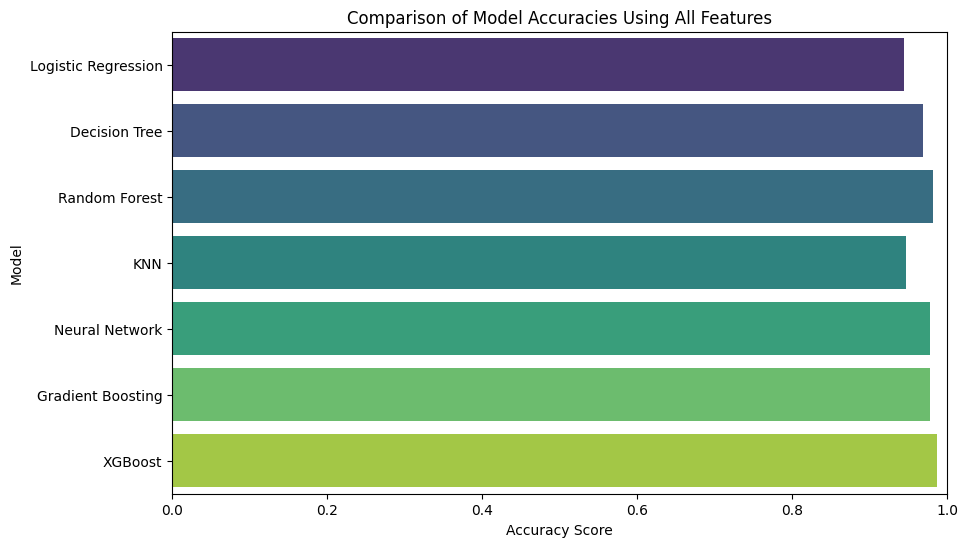

In [ ]:
# Split data
X = df_renamed[all_features]
y = df_renamed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train models and get results
model_results = train_and_evaluate_all_models(X_train, X_test, y_train, y_test)

# Extract accuracy scores
model_names = list(model_results['results'].keys())
accuracies = [model_results['results'][model]['accuracy'] for model in model_names]

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy Score")
plt.ylabel("Model")
plt.title("Comparison of Model Accuracies Using All Features")
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()


## Top ten features analysis

<ipython-input-10-720bf6e37490>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importance, y=top_features, palette='viridis')


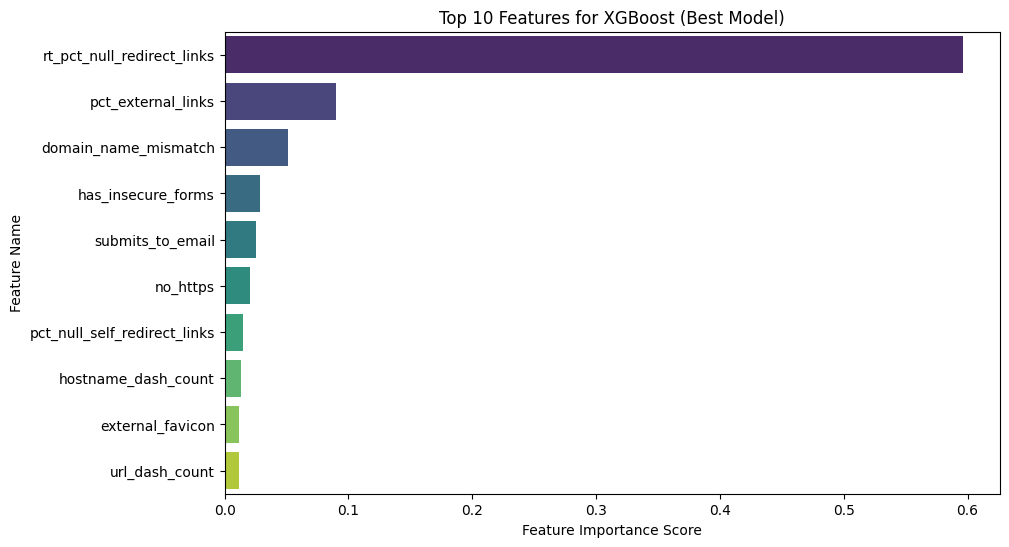

In [ ]:
# Identify the best model (highest accuracy)
best_model_name = model_names[np.argmax(accuracies)]
best_model = model_results['models'][best_model_name]  # Extract best trained model

# Check if the best model has feature importance (only tree-based models do)
if hasattr(best_model, "feature_importances_"):
    feature_importance = best_model.feature_importances_
    feature_names = X_train.columns  # Get feature names

    # Sort and get top 10 features
    sorted_indices = np.argsort(feature_importance)[::-1][:10]
    top_features = np.array(feature_names)[sorted_indices]
    top_importance = feature_importance[sorted_indices]

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_importance, y=top_features, palette='viridis')

    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature Name")
    plt.title(f"Top 10 Features for {best_model_name} (Best Model)")
    plt.show()

else:
    print(f"The selected best model ({best_model_name}) does not support feature importance.")


In [ ]:
import pandas as pd

# Define feature groups
url_structure_features = [
    'url_dot_count', 'subdomain_depth', 'path_depth', 'url_length',
    'url_dash_count', 'hostname_dash_count', 'has_at_symbol',
    'has_tilde_symbol', 'url_underscore_count', 'url_percent_count',
    'query_param_count', 'url_ampersand_count', 'url_hash_count',
    'url_numeric_char_count', 'double_slash_in_path'
]

security_indicators = [
    'no_https', 'has_random_string', 'uses_ip_address',
    'https_in_hostname', 'hostname_length', 'path_length', 'query_length'
]

website_content_features = [
    'domain_in_subdomains', 'domain_in_path', 'sensitive_word_count',
    'has_embedded_brand', 'pct_external_links', 'pct_external_resources',
    'external_favicon', 'has_insecure_forms', 'has_relative_form_action',
    'external_form_submission', 'abnormal_form_action', 'pct_null_self_redirect_links'
]

behavioral_features = [
    'domain_name_mismatch', 'fake_status_bar_link', 'right_click_disabled',
    'has_popup_windows', 'submits_to_email', 'has_iframe_or_frame',
    'missing_title', 'images_only_in_form'
]

realtime_features = [
    'rt_subdomain_depth', 'rt_url_length', 'rt_pct_external_resources',
    'rt_abnormal_form_action', 'rt_external_scripts', 'rt_pct_null_redirect_links'
]

# Combine all feature groups
feature_groups = {
    'URL Structure Features': url_structure_features,
    'Security Indicators': security_indicators,
    'Website Content Features': website_content_features,
    'Behavioral Features': behavioral_features,
    'Realtime Features': realtime_features
}

# Create a table for each group
for group_name, features in feature_groups.items():
    # Subset the DataFrame to include only the columns from the current feature group
    subset_df = df_renamed[features]

    # Calculate the mean for each feature in the group
    means = subset_df.mean()

    # Convert to DataFrame for better presentation
    means_df = means.reset_index()
    means_df.columns = ['Feature', 'Mean Value']

    # Display the table
    print(f"\n{group_name} - Feature Mean Values:\n")
    print(means_df)
    print("\n" + "-"*50)


URL Structure Features - Feature Mean Values:

                   Feature  Mean Value
0            url_dot_count      2.4451
1          subdomain_depth      0.5868
2               path_depth      3.3003
3               url_length     70.2641
4           url_dash_count      1.8180
5      hostname_dash_count      0.1389
6            has_at_symbol      0.0003
7         has_tilde_symbol      0.0131
8     url_underscore_count      0.3232
9        url_percent_count      0.0738
10       query_param_count      0.4586
11     url_ampersand_count      0.2772
12          url_hash_count      0.0023
13  url_numeric_char_count      5.8103
14    double_slash_in_path      0.0009

--------------------------------------------------

Security Indicators - Feature Mean Values:

             Feature  Mean Value
0           no_https      0.9888
1  has_random_string      0.5252
2    uses_ip_address      0.0172
3  https_in_hostname      0.0000
4    hostname_length     18.8243
5        path_length     35.5649



----- Running models on All Features -----

Logistic Regression Results:
Accuracy: 0.8257
Precision: 0.8205
Recall: 0.8445
F1 Score: 0.8323
Confusion Matrix:
[[1179  284]
 [ 239 1298]]

Decision Tree Results:
Accuracy: 0.8553
Precision: 0.8714
Recall: 0.8419
F1 Score: 0.8564
Confusion Matrix:
[[1272  191]
 [ 243 1294]]

Random Forest Results:
Accuracy: 0.8957
Precision: 0.8995
Recall: 0.8966
F1 Score: 0.8980
Confusion Matrix:
[[1309  154]
 [ 159 1378]]

KNN Results:
Accuracy: 0.8883
Precision: 0.8710
Recall: 0.9180
F1 Score: 0.8939
Confusion Matrix:
[[1254  209]
 [ 126 1411]]

Neural Network Results:
Accuracy: 0.9023
Precision: 0.8892
Recall: 0.9245
F1 Score: 0.9065
Confusion Matrix:
[[1286  177]
 [ 116 1421]]

Gradient Boosting Results:
Accuracy: 0.8970
Precision: 0.8703
Recall: 0.9388
F1 Score: 0.9033
Confusion Matrix:
[[1248  215]
 [  94 1443]]

XGBoost Results:
Accuracy: 0.9047
Precision: 0.8927
Recall: 0.9252
F1 Score: 0.9086
Confusion Matrix:
[[1292  171]
 [ 115 1422]]

Best mod

<ipython-input-13-be7b682b6638>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=model_names, palette="viridis")


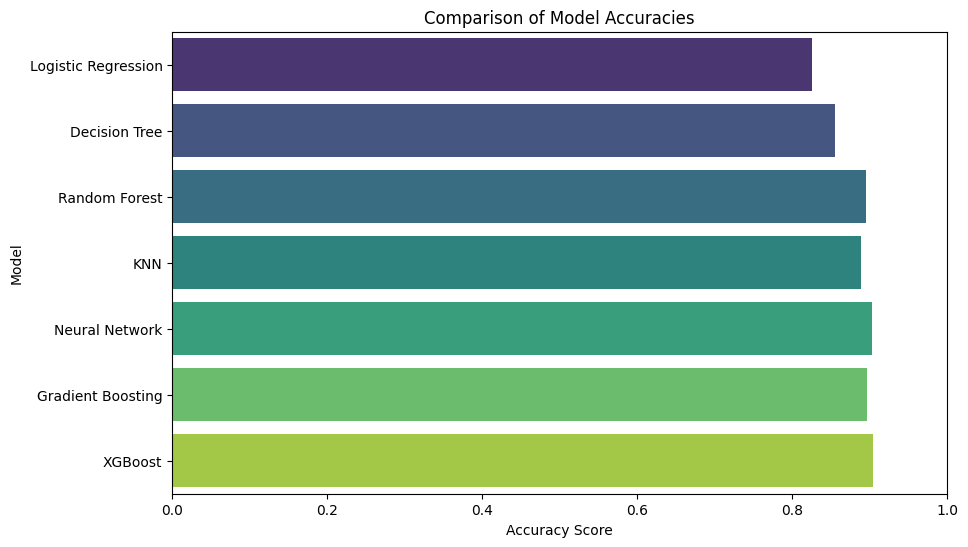

In [ ]:
def compare_model_accuracies(df, feature_list, target, train_and_evaluate_fn):

    # Split data
    X = df[feature_list]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train models and get results
    model_results = train_and_evaluate_fn(X_train, X_test, y_train, y_test)

    # Extract accuracy scores
    model_names = list(model_results['results'].keys())
    accuracies = [model_results['results'][model]['accuracy'] for model in model_names]

    # Create bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=accuracies, y=model_names, palette="viridis")
    plt.xlabel("Accuracy Score")
    plt.ylabel("Model")
    plt.title("Comparison of Model Accuracies")
    plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
    plt.show()

    return model_results

# Example: Running for a subset of features (e.g., URL-based features)
model_results_url = compare_model_accuracies(df_renamed, url_structure_features, target, train_and_evaluate_all_models)


## Hyperparameter Tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
baseline_model = xgb.XGBClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

baseline_acc = accuracy_score(y_test, baseline_pred)
print(f"Baseline XGBoost Accuracy: {baseline_acc:.4f}")


Baseline XGBoost Accuracy: 0.9870


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

important_features = [
    'rt_pct_null_redirect_links',  # 'it_pct_null_redirect_links'
    'pct_external_links',          # 'pct_external_links'
    'domain_name_mismatch',        # 'domain_name_mismatch'
    'has_insecure_forms',          # 'has_insecure_forms'
    'submits_to_email',            # 'submits_to_email'
    'no_https',                    # 'no_https'
    'pct_null_self_redirect_links',# 'pct_null_self_redirect_links'
    'hostname_dash_count',         # 'hostname_dash_count'
    'external_favicon',            # 'external_favicon'
    'url_dash_count'               # 'url_dash_count'
]

# Subset the data to only include the important features
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42)

# GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_important, y_train)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train final model with best hyperparameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_important, y_train)

# Evaluate the final model on the test set
y_pred = best_xgb.predict(X_test_important)
final_acc = accuracy_score(y_test, y_pred)

print(f"Optimized XGBoost Accuracy with Selected Features: {final_acc:.4f}")

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Optimized XGBoost Accuracy with Selected Features: 0.9660


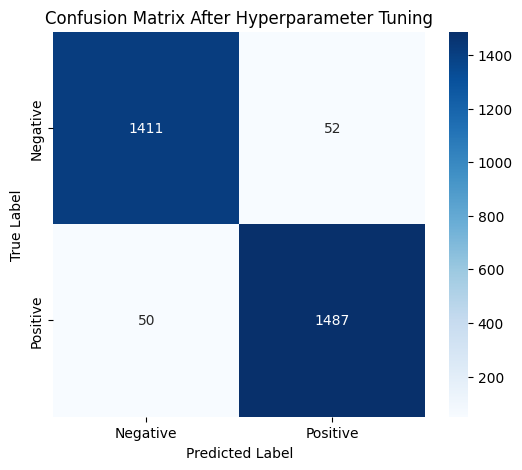

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Predict the labels for the test set after hyperparameter tuning
y_pred = best_xgb.predict(X_test_important)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix After Hyperparameter Tuning")
plt.show()

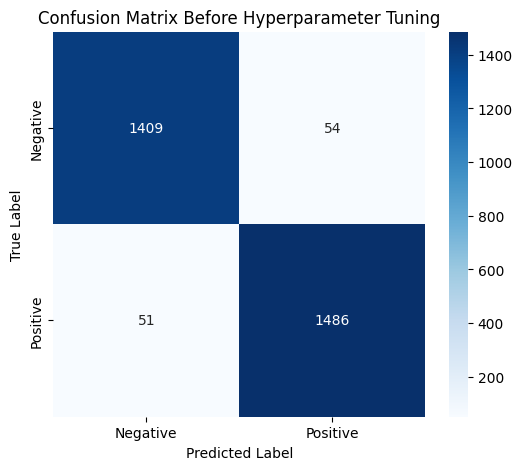

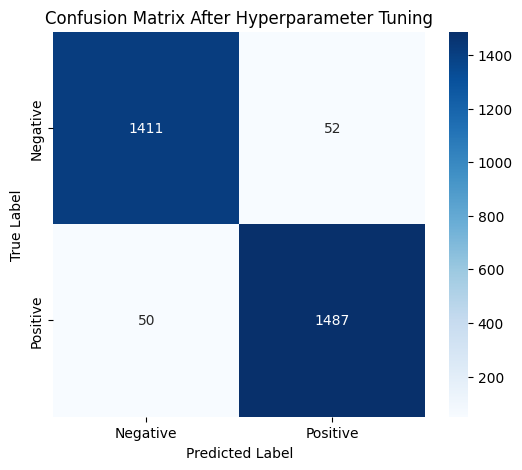

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Predict the labels for the test set before hyperparameter tuning
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_important, y_train)
y_pred_before = xgb_model.predict(X_test_important)

# Compute the confusion matrix before tuning
cm_before = confusion_matrix(y_test, y_pred_before)

# Plot the heatmap for confusion matrix before tuning
plt.figure(figsize=(6, 5))
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Before Hyperparameter Tuning")
plt.show()

# Predict the labels for the test set after hyperparameter tuning
y_pred = best_xgb.predict(X_test_important)

# Compute the confusion matrix after tuning
cm_after = confusion_matrix(y_test, y_pred)

# Plot the heatmap for confusion matrix after tuning
plt.figure(figsize=(6, 5))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix After Hyperparameter Tuning")
plt.show()

In [ ]:
# Before hyperparameter tuning
acc_before = accuracy_score(y_test, y_pred_before) * 100
f1_before = f1_score(y_test, y_pred_before) * 100
recall_before = recall_score(y_test, y_pred_before) * 100
precision_before = precision_score(y_test, y_pred_before) * 100

# After hyperparameter tuning
acc_after = accuracy_score(y_test, y_pred) * 100
f1_after = f1_score(y_test, y_pred) * 100
recall_after = recall_score(y_test, y_pred) * 100
precision_after = precision_score(y_test, y_pred) * 100

# Print results as percentages with one decimal place
print("Before Hyperparameter Tuning:")
print(f"Accuracy: {acc_before:.1f}%")
print(f"F1 Score: {f1_before:.1f}%")
print(f"Recall: {recall_before:.1f}%")
print(f"Precision: {precision_before:.1f}%")

print("\nAfter Hyperparameter Tuning:")
print(f"Accuracy: {acc_after:.1f}%")
print(f"F1 Score: {f1_after:.1f}%")
print(f"Recall: {recall_after:.1f}%")
print(f"Precision: {precision_after:.1f}%")


Before Hyperparameter Tuning:
Accuracy: 96.5%
F1 Score: 96.6%
Recall: 96.7%
Precision: 96.5%

After Hyperparameter Tuning:
Accuracy: 96.6%
F1 Score: 96.7%
Recall: 96.7%
Precision: 96.6%


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Your important features
important_features = [
    'rt_pct_null_redirect_links',
    'pct_external_links',
    'domain_name_mismatch',
    'has_insecure_forms',
    'submits_to_email',
    'no_https',
    'pct_null_self_redirect_links',
    'hostname_dash_count',
    'external_favicon',
    'url_dash_count'
]

# Subset the data to only include the important features
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# Define the refined hyperparameter grid based on best hyperparameters from the previous search
param_grid = {
    "n_estimators": [150, 200, 250],  # Refined based on prior n_estimators = 200
    "max_depth": [8, 10, 12],          # Refined based on prior max_depth = 10
    "learning_rate": [0.05, 0.1, 0.2],  # Refined based on prior learning_rate = 0.1
    "subsample": [0.7, 0.8, 1.0],      # Refined based on prior subsample = 0.8
    "colsample_bytree": [0.6, 0.7, 0.8]  # Refined based on prior colsample_bytree = 0.6
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42)

# GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_important, y_train)

# Print best hyperparameters
print("Refined Best Hyperparameters:", grid_search.best_params_)

# Train final model with refined best hyperparameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_important, y_train)

# Evaluate the final model on the test set
y_pred = best_xgb.predict(X_test_important)
final_acc = accuracy_score(y_test, y_pred)

print(f"Refined XGBoost Accuracy with Selected Features: {final_acc:.4f}")

Refined Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Refined XGBoost Accuracy with Selected Features: 0.9660


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

important_features = [
    'rt_pct_null_redirect_links',  # 'it_pct_null_redirect_links'
    'pct_external_links',          # 'pct_external_links'
    'domain_name_mismatch',        # 'domain_name_mismatch'
    'has_insecure_forms',          # 'has_insecure_forms'
    'submits_to_email',            # 'submits_to_email'
    'no_https',                    # 'no_https'
    'pct_null_self_redirect_links',# 'pct_null_self_redirect_links'
    'hostname_dash_count',         # 'hostname_dash_count'
    'external_favicon',            # 'external_favicon'
    'url_dash_count'               # 'url_dash_count'
]

# Subset the data to only include the important features
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],  # Based on the best result of 200, extending the range
    "max_depth": [6, 10, 12],          # Based on the best result of 10, adding a slightly higher depth for exploration
    "learning_rate": [0.05, 0.1, 0.15],  # Narrowing learning rate range based on optimal result of 0.1
    "subsample": [0.7, 0.8, 0.9],      # Adjusted to a narrower range based on optimal value of 0.8
    "colsample_bytree": [0.6, 0.7, 0.8]  # Slightly narrowed range based on optimal result of 0.6
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42)

# GridSearchCV to tune the hyperparameters
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_important, y_train)

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train final model with best hyperparameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_important, y_train)

# Evaluate the final model on the test set
y_pred = best_xgb.predict(X_test_important)
final_acc = accuracy_score(y_test, y_pred)

print(f"Optimized XGBoost Accuracy with Selected Features: {final_acc:.4f}")

Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Optimized XGBoost Accuracy with Selected Features: 0.9660


## Conclusions

### Question 1
How accurately can our machine learning model distinguish between phishing and legitimate websites using the given dataset's 48 features?

Our best-performing model, XGBoost, achieved:

Accuracy: 98.70%

Precision: 98.57%

Recall: 98.89%

F1 Score: 98.73%

This indicates that the model can very accurately distinguish between phishing and legitimate websites. It not only catches nearly all phishing sites (high recall) but also avoids misclassifying legitimate ones (high precision), making it suitable for real-world deployment.

### Question 2
Which features contribute the most to the identification of phishing websites, and how do they influence the model's decision-making process?

Top features identified by tree-based models include:

pct_external_links: High percentages of links pointing to external domains are common in phishing sites.

domain_name_mismatch: Phishing sites often display a domain name that doesn’t match the actual destination.

rt_pct_null_redirect_links: Indicates the use of broken or deceptive redirects.

form_handler_external: Submitting user input to unknown or external sources is a key phishing trait.

uses_ip_address: Phishing URLs often use raw IP addresses instead of domain names.

These features influence model predictions by capturing the structural and behavioral red flags that are typical of phishing websites.

### Question 3
What are the differences in behavioral patterns (e.g., form submissions, redirects) between phishing and legitimate websites, and how can these patterns improve phishing detection?

In [ ]:
import pandas as pd

# Updated behavioral features based on your slide grouping
behavioral_features = [
    'domain_name_mismatch',       # FrequentDomainNameMismatch
    'fake_status_bar_link',       # FakeLinkInStatusBar
    'right_click_disabled',       # RightClickDisabled
    'has_popup_windows',          # PopUpWindow
    'submits_to_email',           # SubmitInfoToEmail
    'has_iframe_or_frame',        # IframeOrFrame
    'missing_title',              # MissingTitle
    'images_only_in_form'         # ImagesOnlyInForm
]

# Group by phishing vs. legitimate and calculate mean
grouped_behavior = df.groupby('is_phishing')[behavioral_features].mean()

# Rename index for readability
grouped_behavior.index = ['Legitimate (0)', 'Phishing (1)']

# Sort and display results
print("\n=== Behavioral Feature Averages by Class ===")
print(grouped_behavior.T.sort_values(by='Phishing (1)', ascending=False))

Behavioral differences that the model learns to detect include:
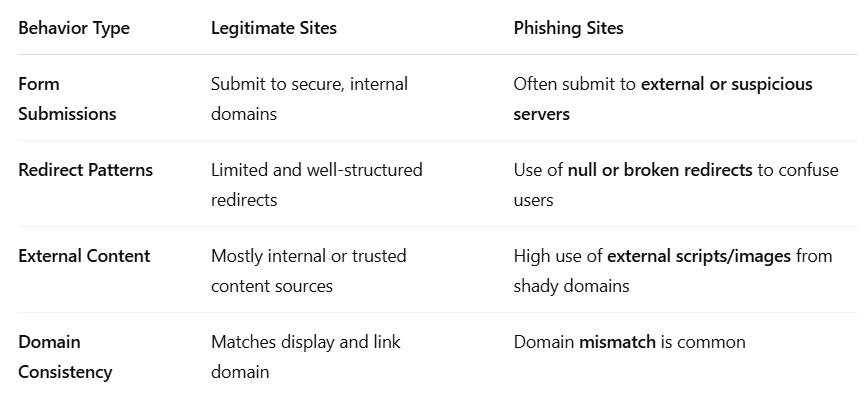

These patterns improve phishing detection by capturing how the site behaves, rather than how it looks — making them harder for attackers to fake.

### Question 4
How do different classification algorithms (e.g., logistic regression, decision trees, random forests, neural networks) compare in terms of accuracy, precision, and recall when detecting phishing websites?

XGBoost is the top performer, followed closely by Random Forest and Gradient Boosting. Simpler models like Logistic Regression still do well, while KNN lags behind. This shows that tree-based ensemble models are particularly effective for phishing detection on this dataset.

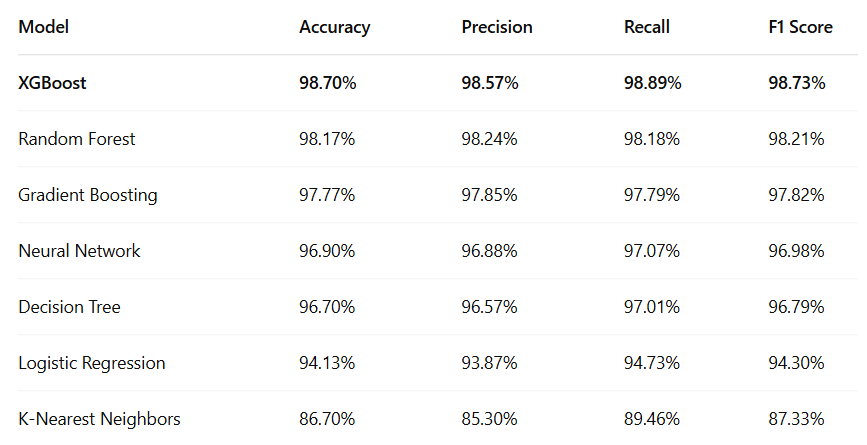